# Predicting Higher Highs Using Machine Learning Algorithms

### Corneliu Caraba - Lewis University Master Thesis Program Attachment

This is the program used to collect data for the Master Thesis entitled "Predicting Higher Highs" 
Use this program at your own risk. 

### Disclamer - MUST READ
#### The information provided here is for research purposes only and is not intended for trading purposes or advice. I am not to be held responsible for any legal, financial or other advice. I am also not making any recommendations or endorsements of any investments. The information presented here does not constitute advice and you should not rely on it to make any decision or take any action. This is not a recommendation for buying or selling any stocks, securities, assets, or options.

### Past Performance Does Not Guarantee Future Results!

## General Imports

General imports used for downloading data from Yahoo Finance, creating dataframes, calculating feautures and technical analysis indicators.

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import preprocessing
import talib

%matplotlib inline

## Raw Data Download
This section will download data and save it using csv file for different stock. Ten year of historical dayily data will be used

In [3]:
# downloading data from Yahoo Finance
start = "2010-01-01"
end = "2020-08-25" # day to predict
ticker = "SPY"
data = yf.download(ticker, start, end)
data.to_csv('data_csv')
today = end;

[*********************100%***********************]  1 of 1 completed


In [4]:
# saving data to csv file 
data.to_csv('data_csv')

In [5]:
# reading the csv file
df = pd.read_csv('data_csv', parse_dates=True, index_col='Date')

In [6]:
# day to be predicted (most recent day from the data)
predict_day = df.index[-1]
print('Prediction is for the following day:', end)

Prediction is for the following day: 2020-08-25


## Calculating Features
In this Section lots of features have been calculated. Not all feauters calculated here were used in the classification models.

In [7]:
# create rate of return (percent of change)
df["Return"] = df['Adj Close']/df['Adj Close'].shift(1) - 1

# calculating moving averages
df['SMA3']=df['Close'].rolling(window=3).mean()
df['SMA5']=df['Close'].rolling(window=5).mean()
df['SMA10']=df['Close'].rolling(window=10).mean()
df['SMA20']=df['Close'].rolling(window=20).mean()
df['SMA50']=df['Close'].rolling(window=50).mean()
df['SMA100']=df['Close'].rolling(window=100).mean()
df['SMA200']=df['Close'].rolling(window=200).mean()

# calculating differences between price and moving averages
df['Close_Vs_3SMA'] = df['Close'] - df['SMA3']
df['Close_Vs_5SMA'] = df['Close'] - df['SMA5']
df['Close_Vs_10SMA'] = df['Close'] - df['SMA10']
df['Close_Vs_20SMA'] = df['Close'] - df['SMA20']
df['Close_Vs_50SMA'] = df['Close'] - df['SMA50']
df['Close_Vs_100SMA'] = df['Close'] - df['SMA100']
df['Close_Vs_200SMA'] = df['Close'] - df['SMA200']

# calculate difference between SMAs
df['3SMA_Vs_5SMA'] = df['SMA3'] - df['SMA5']
df['5SMA_Vs_10SMA'] = df['SMA5'] - df['SMA10']
df['10SMA_Vs_20SMA'] = df['SMA10'] - df['SMA20']
df['20SMA_Vs_50SMA'] = df['SMA20'] - df['SMA50']
df['50SMA_Vs_100SMA'] = df['SMA50'] - df['SMA100']
df['50SMA_Vs_200SMA'] = df['SMA50'] - df['SMA200']


# calculate and add RSI momentum indicators
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
df['RSI_10'] = talib.RSI(df['Close'], timeperiod=10)
df['RSI_5'] = talib.RSI(df['Close'], timeperiod=5)

# calculate and MACD values
df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(df['Close'],
                                                          fastperiod=12, 
                                                          slowperiod=26, 
                                                          signalperiod=9)

## Preprocessing Data

In [8]:
# deleting NaN values from data
df.dropna(inplace=True)

### Data Features
In this section the matrix of features used is created and normalized. The matrix will be entitle X and later split into X_train and X_test for feeding it into the models for prediction.

In [9]:
# features to be used in prediction
features = ['Return','Close_Vs_3SMA', 'Close_Vs_5SMA', 'Close_Vs_10SMA', 
            'Close_Vs_20SMA','Close_Vs_50SMA','Close_Vs_100SMA','Close_Vs_200SMA',
            '3SMA_Vs_5SMA','5SMA_Vs_10SMA','10SMA_Vs_20SMA','20SMA_Vs_50SMA',
            '50SMA_Vs_200SMA','RSI_14', 'RSI_10','RSI_5','macd','macdsignal', 'macdhist']
# creating the matrix of the features
all_features = df[features].values

In [10]:
# Normalizing the feature matrix
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_features_scaled = scaler.fit_transform(all_features)

In [11]:
# dropping lat day which has no label and naming the future matrix X

X = all_features_scaled[:-1]

In [12]:
# last day of data (has no label - need to predict)
last_day = all_features_scaled[-1]

### Data Labels
In this section the labels needed for classification are created. The labels vector will be entitle y which will later be split into y_train and y_test.

In [13]:
#creating label
higher_high = df['High'].gt(df['High'].shift())
df['Tomorrow Higher High'] = higher_high.shift(-1)
df.dropna(inplace=True)

In [14]:
# creating classes
y = df['Tomorrow Higher High'].values.astype(int)

In [15]:
# checking size of features matrix and class vector (must have same number or rows)
print(X.shape, y.shape)

(2479, 19) (2479,)


### Split Data
In this section the data it split into train and test. The train data will be used to fit the models while test data to check accuracy of the model.

In [16]:
# splitting data into train and test data
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X, y, train_size=0.70, random_state=1)
print('Number of days for testing data: ',len(X_test))
print('Number of days for training data:', len(X_train))

Number of days for testing data:  744
Number of days for training data: 1735


### Test Data Basic Statistics
Some basic statistics are calculated in this section.

In [17]:
total_test = len(y)
increase = sum(y)
not_increase = total_test - increase

In [18]:
print('Days of higher highs: ', increase)
print('Days of not increase:', not_increase)

Days of higher highs:  1351
Days of not increase: 1128


In [19]:
print("Percent of higher highs: ", increase/total_test)
print("Percent of not increase: ", not_increase/total_test)

Percent of higher highs:  0.54497781363453
Percent of not increase:  0.4550221863654699


In [20]:
# function for calculating precision
def precision(cm):
    precision = tp / (tp+fp)
    return precision

# function for calculating recall
def recall(cm):
    recall = tp / (tp+fn)
    return recall

## Classification Models
In this section different Classification Models Algorithms are used to predict if the stock has a higher high or not for the next day.

In [21]:
print('Prediction Day is :', predict_day)

Prediction Day is : 2020-08-24 00:00:00


In [22]:
# metrics imports
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

In [23]:
# function to print results
count = 0 # keep track of models that predict higher highs
def printResults():
    print(model, "Results\n")
    print("Precission: ", precision(cm))
    print("Recall: ", recall(cm))
    cv_scores = cross_val_score(clf, X, y)
    print("Cross Validation Score: ", cv_scores.mean())
    print("\nAccoridng to ", model)
    result = clf.predict([last_day])
    if result < 1:
        print(ticker, " will not print a higher high on", end)
    elif result == 1:
        print(ticker, " will reach a higher high on ", end, " with a precision of: ", precision(cm))
        global count
        count += 1
    print("\nWARNING\nPast Data Does Not Guarantee Future Results!")

### Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = "Random Forest"
clf = RandomForestClassifier(n_estimators=100, max_depth = 5, max_features = 10, 
                             min_samples_leaf = 4, min_samples_split = 14, random_state=1)
clf.fit(X_train,y_train)
cv_scores = cross_val_score(clf, X, y)

print("Cross Validation Score: ", cv_scores.mean())

Cross Validation Score:  0.6199975562072335


#### Confustion Matrix for Random Forest

Confusion Matrix for  Random Forest SPY


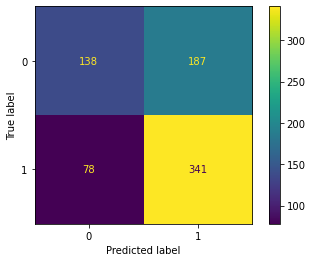

In [25]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for ", model, ticker)
disp = plot_confusion_matrix(clf,X_test, y_test)

### Precision and Recall

Precision is known as positive predictive value and is the proportion of relevant instances among the retrieved instances. In other words, it answer the question "What proportion of positive identifications was actually correct?"

Recall i known as the sensitivity or the hit rate which is the true positive rate (TPR) and is the proportion of the total amount of relevant instances that were acually retrieved. It answer the question "What proportion of actual positives wea identified correctly?

In [26]:
# identifying confusion matrix labels
tn = cm[0][0]
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

In [27]:
model = "Random Forest Classifier"
print(model)
print("Precission: ", precision(cm))
print("Recall: ", recall(cm))

Random Forest Classifier
Precission:  0.6458333333333334
Recall:  0.8138424821002387


##### Prediction

In [28]:
printResults()

Random Forest Classifier Results

Precission:  0.6458333333333334
Recall:  0.8138424821002387
Cross Validation Score:  0.6199975562072335

Accoridng to  Random Forest Classifier
SPY  will reach a higher high on  2020-08-25  with a precision of:  0.6458333333333334

WARNING
Past Data Does Not Guarantee Future Results!


## Support Vector Machine Classifier

In [29]:
from sklearn.svm import SVC

##### SVC kernel = linear

In [30]:
clf = SVC(kernel = 'linear', C = 1000)
model = "SVM (linear)"

In [31]:
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X, y)
print("Cross Validation Score: ", cv_scores.mean())

Cross Validation Score:  0.6123338220918866


Confusion Matrix for  SVM (linear) SPY


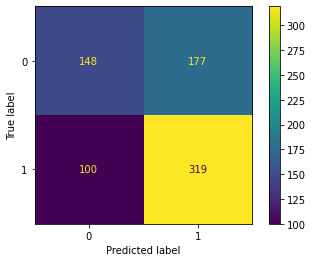

In [32]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for ", model, ticker)
disp = plot_confusion_matrix(clf,X_test, y_test)

In [33]:
# identifying confusion matrix labels
tn = cm[0][0]
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

In [34]:
printResults()

SVM (linear) Results

Precission:  0.6431451612903226
Recall:  0.7613365155131265
Cross Validation Score:  0.6123338220918866

Accoridng to  SVM (linear)
SPY  will reach a higher high on  2020-08-25  with a precision of:  0.6431451612903226

WARNING
Past Data Does Not Guarantee Future Results!


##### SVC kernel = poly

In [35]:
model = "SVM (poly)"
clf = SVC(kernel = 'poly', degree = 2, C = 1)
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X, y)
print("Cross Validation Score: ", cv_scores.mean())

Cross Validation Score:  0.6107249918540241


Confusion Matrix for  SVM (poly) SPY


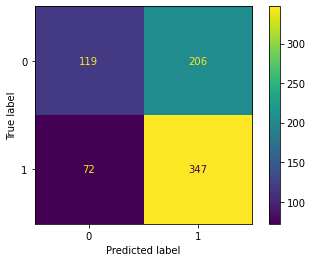

In [36]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for ", model, ticker)
disp = plot_confusion_matrix(clf,X_test, y_test)

In [37]:
# identifying confusion matrix labels
tn = cm[0][0]
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

In [38]:
printResults()

SVM (poly) Results

Precission:  0.6274864376130199
Recall:  0.8281622911694511
Cross Validation Score:  0.6107249918540241

Accoridng to  SVM (poly)
SPY  will reach a higher high on  2020-08-25  with a precision of:  0.6274864376130199

WARNING
Past Data Does Not Guarantee Future Results!


### Logistic Regression Classifier

In [39]:
model = "Logistic Regression"
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty = 'l2', solver = 'lbfgs', C = 0.99)
clf.fit(X_train, y_train)

LogisticRegression(C=0.99)

Confusion Matrix for  Logistic Regression SPY


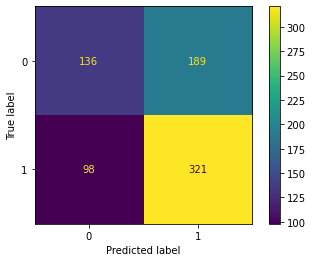

In [40]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for ", model, ticker)
disp = plot_confusion_matrix(clf,X_test, y_test)

In [41]:
# identifying confusion matrix labels
tn = cm[0][0]
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

In [42]:
print(model, ticker)
cv_scores = cross_val_score(clf, X, y)
print("Cross Validation Score: ", cv_scores.mean())
print("Precission: ", precision(cm))
print("Recall: ", recall(cm))

Logistic Regression SPY
Cross Validation Score:  0.60225073313783
Precission:  0.6294117647058823
Recall:  0.766109785202864


In [43]:
printResults()

Logistic Regression Results

Precission:  0.6294117647058823
Recall:  0.766109785202864
Cross Validation Score:  0.60225073313783

Accoridng to  Logistic Regression
SPY  will reach a higher high on  2020-08-25  with a precision of:  0.6294117647058823

WARNING
Past Data Does Not Guarantee Future Results!


### KNN

In [44]:
from sklearn import neighbors

model = "K-Nearest Neighbors"
clf = neighbors.KNeighborsClassifier(n_neighbors=25)
clf.fit(X,y)
cv_scores = cross_val_score(clf, X, y, cv=10)

cv_scores.mean()

0.5736074833485699

Confusion Matrix for  K-Nearest Neighbors SPY


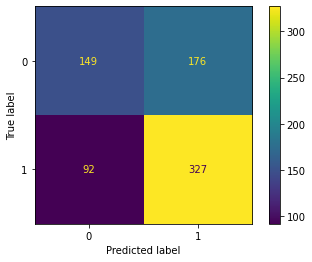

In [45]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for ", model, ticker)
disp = plot_confusion_matrix(clf,X_test, y_test)

In [46]:
# identifying confusion matrix labels
tn = cm[0][0]
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

In [47]:
print(model, ticker)
cv_scores = cross_val_score(clf, X, y)
print("Cross Validation Score: ", cv_scores.mean())
print("Precission: ", precision(cm))
print("Recall: ", recall(cm))

K-Nearest Neighbors SPY
Cross Validation Score:  0.5832885304659499
Precission:  0.6500994035785288
Recall:  0.7804295942720764


In [48]:
printResults()

K-Nearest Neighbors Results

Precission:  0.6500994035785288
Recall:  0.7804295942720764
Cross Validation Score:  0.5832885304659499

Accoridng to  K-Nearest Neighbors
SPY  will reach a higher high on  2020-08-25  with a precision of:  0.6500994035785288

WARNING
Past Data Does Not Guarantee Future Results!


In [50]:
print("Out of 5 models, ",count, "predicted higher highs on", end, "for", ticker)
print("Number of days used for training the model: ", len(y_train))
print("Number of days used to test the model: ", len(y_test))
print("Total days of data used: ", len(y), "or approximately", len(y)/252, "years." )
print("\nHave a nice day :)")

Out of 5 models,  5 predicted higher highs on 2020-08-25 for SPY
Number of days used for training the model:  1735
Number of days used to test the model:  744
Total days of data used:  2479 or approximately 9.837301587301587 years.

Have a nice day :)
